# Fake news classifier

## 0 - Load neccessary libraries

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,SGD

In [ ]:
import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 1 - Load datasets from google drive

In [ ]:
# - Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 - Explore dataset

In [ ]:
#Read the data
data = '/content/drive/My Drive/Data/FakeNews/news.csv'
df=pd.read_csv(data)
#Get shape and head
df.head()

Unnamed: 0  ... label
0        8476  ...  FAKE
1       10294  ...  FAKE
2        3608  ...  REAL
3       10142  ...  FAKE
4         875  ...  REAL

[5 rows x 4 columns]

In [ ]:
df.shape

(6335, 4)

In [ ]:
df.text[10]

'CEDAR RAPIDS, Iowa — “I had one of the most wonderful rallies of my entire career right here in 1992,” Bill Clinton said by way of opening to the crowd of more than 1,100 on Saturday night.\n\nTwo days before the Iowa caucuses, Cedar Rapids tried to deliver that same old feeling to his wife, Hillary Clinton.\n\nIn the crowd,\xa0one woman held a sign that said “227 years of men. It’s HER turn!" Some carried signs and books. Others had traveled from as far as Missouri. They had waited hours, even after the fire marshal told them there was no more room inside the high school gymnasium.\n\nThe restive crowd chanted slogans and buzzed with anticipation until finally Bill, Hillary and Chelsea Clinton all appeared on stage hand-in-hand, an hour behind schedule. As they roared, Hillary Clinton beamed.\n\nIt has been a long slog in Iowa for the Clinton campaign, which has struggled mightily to shake the label that its supporters can’t muster the enthusiasm of its rival’s backers. As the caucus

In [ ]:
x = df['text']
y = df['label']

In [ ]:
x.head()

0    Daniel Greenfield, a Shillman Journalism Fello...
1    Google Pinterest Digg Linkedin Reddit Stumbleu...
2    U.S. Secretary of State John F. Kerry said Mon...
3    — Kaydee King (@KaydeeKing) November 9, 2016 T...
4    It's primary day in New York and front-runners...
Name: text, dtype: object

In [ ]:
y.head()

0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

## 3 - Data prepocessing

In [ ]:
# - def lemmatize function
def get_lemmatize(token,tag):
    lemmatizer = WordNetLemmatizer()
    noun_tags = ['NN','NNP','NNPS','NNS']
    verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
    if tag in noun_tags:
        return lemmatizer.lemmatize(token,'n')
    elif tag in verb_tags:
        return lemmatizer.lemmatize(token,'v')
    else:
        return lemmatizer.lemmatize(token,'n')

In [ ]:
# - def preprocessing function
def get_preprocessed_text(text):
    stop_words = stopwords.words('english')
    splited_text = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())
    tokens = [word for sent in nltk.sent_tokenize(splited_text) for word in nltk.word_tokenize(sent)]
    tokens = [word.lower() for word in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    #tokens = [word for word in tokens if len(word)>=3]
    tokens_with_tag = pos_tag(tokens)
    preprocessed_text =   " ".join([get_lemmatize(token,tag) for token,tag in tokens_with_tag])
    return preprocessed_text

In [ ]:
%%time
x_processed = [get_preprocessed_text(text) for text in x]

CPU times: user 2min 51s, sys: 356 ms, total: 2min 52s
Wall time: 2min 52s


In [ ]:
x[10]

'CEDAR RAPIDS, Iowa — “I had one of the most wonderful rallies of my entire career right here in 1992,” Bill Clinton said by way of opening to the crowd of more than 1,100 on Saturday night.\n\nTwo days before the Iowa caucuses, Cedar Rapids tried to deliver that same old feeling to his wife, Hillary Clinton.\n\nIn the crowd,\xa0one woman held a sign that said “227 years of men. It’s HER turn!" Some carried signs and books. Others had traveled from as far as Missouri. They had waited hours, even after the fire marshal told them there was no more room inside the high school gymnasium.\n\nThe restive crowd chanted slogans and buzzed with anticipation until finally Bill, Hillary and Chelsea Clinton all appeared on stage hand-in-hand, an hour behind schedule. As they roared, Hillary Clinton beamed.\n\nIt has been a long slog in Iowa for the Clinton campaign, which has struggled mightily to shake the label that its supporters can’t muster the enthusiasm of its rival’s backers. As the caucus

In [ ]:
x_processed[10]

'cedar rapid iowa — “ one wonderful rally entire career right 1992 ” bill clinton say way open crowd 1 100 saturday night two day iowa caucus cedar rapid try deliver old feel wife hillary clinton crowd one woman hold sign say “ 227 year men ’ turn carry sign book others travel far missouri waited hour even fire marshal tell room inside high school gymnasium restive crowd chant slogan buzz anticipation finally bill hillary chelsea clinton appear stage hand hand hour behind schedule roar hillary clinton beam long slog iowa clinton campaign struggle mightily shake label supporter ’ muster enthusiasm rival ’ backer caucus near help former president energy level event notably dial charismatic speaker say cigi ross 31 general say bigger draw people monday night put campaign month work test campaign ’ organization bring supporter candidate energize voter clinton seem draw higher usual energy stand center deliver confident closing statement “ need plan commitment ” clinton say top voice “ yes 

## 4 - Word vectorization

In [ ]:
# Encoding categorical data
labelencoder = LabelEncoder()
y_new = labelencoder.fit_transform(y)
y_new

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
#Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7,max_features= 10000)
x_tfidf=tfidf_vectorizer.fit_transform(x_processed) 
#Split the dataset
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(x_tfidf, y_new, test_size=0.2, random_state=7)

In [ ]:
x_train,y_train = x_train_tfidf,y_train_tfidf
x_test,y_test = x_test_tfidf,y_test_tfidf

## 5 - Applying Machine Learning

### 5.1 - Passive Aggressive Classifier

In [ ]:
# Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
param_grid = dict(C=np.linspace(1,10,10))
classifier = pac

In [ ]:
# use GridSearch to fine the best model parameter
grid = GridSearchCV(classifier, param_grid=param_grid, cv= 3, n_jobs=-1)
grid.fit(x_train, y_train)
clf = grid.best_estimator_ 
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
best_param = grid.best_params_
model_accuracy = "{:1.2f}".format(100*accuracy_score(y_test,y_pred))
print("Accuracy score: {} best parameters:{}".format(model_accuracy,best_param))

Accuracy score: 92.58 best parameters:{'C': 5.0}


In [ ]:
#Build confusion matrix
confusion_matrix(y_test,y_pred)

array([[586,  52],
       [ 42, 587]])

### 5.2 - Neural Network

### 5.2.1 - Simple architecture

In [ ]:
# Define Fake News Classifier Function
def FakeNewsClassifierFunction(input_shape,loss='binary_crossentropy',optimizer = 'RMSprop',accuracy= 'accuracy'):
    FakeNewsClassifier = Sequential([
      Embedding(input_shape, 128),
      LSTM(64, dropout=0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid')])
    # -- Complier FakeNewsClassifier
    FakeNewsClassifier.compile(loss=loss, optimizer = optimizer, metrics=[accuracy])
    return FakeNewsClassifier

In [ ]:
# - initialize the model
model = FakeNewsClassifierFunction(input_shape=10000)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,335,681
Trainable params: 1,335,681
Non-trainable params: 0
______________________________________________

In [ ]:
batch_size = 32
epochs = 10
validation_data = (x_test.todense(),y_test)

In [ ]:
history = model.fit(x_train.todense(),y_train,epochs=epochs,batch_size = batch_size,validation_data=validation_data)

Epoch 1/10
159/159 [==============================] - 62s 387ms/step - loss: 0.6940 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 2/10
159/159 [==============================] - 60s 379ms/step - loss: 0.6937 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 3/10
159/159 [==============================] - 61s 383ms/step - loss: 0.6939 - accuracy: 0.4931 - val_loss: 0.6935 - val_accuracy: 0.4964
Epoch 4/10
159/159 [==============================] - 61s 382ms/step - loss: 0.6936 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 5/10
159/159 [==============================] - 60s 379ms/step - loss: 0.6938 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 6/10
159/159 [==============================] - 59s 374ms/step - loss: 0.6934 - accuracy: 0.4905 - val_loss: 0.6933 - val_accuracy: 0.4964
Epoch 7/10
159/159 [==============================] - 59s 374ms/step - loss: 0.6935 - accuracy: 0.4982 - val_loss: 0.6932 - val_ac

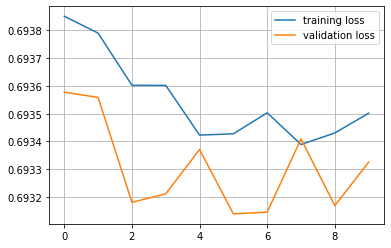

In [ ]:
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.grid()
plt.legend()

### 5.2.2 - Try Deeper networks

In [ ]:
# Define Fake News Classifier Function
def FakeNewsClassifierFunction(input_shape,loss='binary_crossentropy',optimizer = 'RMSprop',accuracy= 'accuracy'):
    FakeNewsClassifier = Sequential([
      Embedding(input_shape, 128),
      LSTM(64, dropout=0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid')])
    # -- Complier FakeNewsClassifier
    FakeNewsClassifier.compile(loss=loss, optimizer = optimizer, metrics=[accuracy])
    return FakeNewsClassifier

In [ ]:
# - initialize the model
deep_model = FakeNewsClassifierFunction(input_shape=(10000))
deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [ ]:
history = deep_model.fit(x_train.todense(),y_train,epochs=epochs,batch_size = batch_size,validation_data=validation_data)

Epoch 1/10
159/159 [==============================] - 60s 380ms/step - loss: 0.6940 - accuracy: 0.4941 - val_loss: 0.6934 - val_accuracy: 0.5036
Epoch 2/10
159/159 [==============================] - 60s 377ms/step - loss: 0.6937 - accuracy: 0.4945 - val_loss: 0.6933 - val_accuracy: 0.5036
Epoch 3/10
159/159 [==============================] - 60s 377ms/step - loss: 0.6934 - accuracy: 0.4992 - val_loss: 0.6934 - val_accuracy: 0.5036
Epoch 4/10
159/159 [==============================] - 60s 375ms/step - loss: 0.6937 - accuracy: 0.4818 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 5/10
159/159 [==============================] - 60s 376ms/step - loss: 0.6935 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 6/10
159/159 [==============================] - 60s 375ms/step - loss: 0.6935 - accuracy: 0.4925 - val_loss: 0.6932 - val_accuracy: 0.5036
Epoch 7/10
159/159 [==============================] - 60s 375ms/step - loss: 0.6935 - accuracy: 0.4961 - val_loss: 0.6931 - val_ac

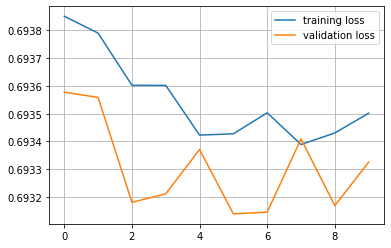

In [ ]:
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.grid()
plt.legend()

In [ ]:
#adam = Adam(lr=0.05)
#sgd = SGD(lr = 0.1, decay = 1e-6, momentum = 0.9)

## 6 - Conclusion